## Tensorflow v 1.15
### Basic classification

In [63]:
import tensorflow.compat.v1 as tf
import numpy as np
import pandas as pd

In [64]:
tf.version

<module 'tensorflow.compat.v1.version' from 'C:\\Users\\user\\Anaconda3\\lib\\site-packages\\tensorflow\\_api\\v2\\compat\\v1\\version\\__init__.py'>

In [65]:
tf.compat.v1.disable_eager_execution()

## Titanic dataset

Datasets EDA are in the other notebook

In [177]:
data = pd.read_csv('Titanic.csv', index_col=0)
data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [178]:
data.drop(['Name', 'Ticket', "Cabin", 'Embarked'], axis=1, inplace=True)

#### Titanic dataset columns

- Survived (TARGET): Flag, true if passanger survived accident
- PClass: 1 for 1st class, 2 for 2nd, 3 for 3rd (cat feature)
- Sex (cat feature)
- Age
- SibSp amount of siblings on the board
- Parch amount of parents/children on the board
- Fare 


In [179]:
data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
PassengerId,,,,,,,
1,0,3,male,22.0,1,0,7.2500
2,1,1,female,38.0,1,0,71.2833
3,1,3,female,26.0,0,0,7.9250
4,1,1,female,35.0,1,0,53.1000
5,0,3,male,35.0,0,0,8.0500
...,...,...,...,...,...,...,...
887,0,2,male,27.0,0,0,13.0000
888,1,1,female,19.0,0,0,30.0000
889,0,3,female,NaN,1,2,23.4500


In [180]:
from sklearn.model_selection import train_test_split

cat_cols = ['Pclass', 'Sex']
num_cols = ['Age', 'SibSp', 'Parch', 'Fare']
y = data['Survived']
X = data.drop('Survived', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=13, stratify=y_train)

In [181]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

num_trans = Pipeline(steps=[
    ('imputer', KNNImputer()),
    
])
cat_trans = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer(
transformers =[
    ('num', num_trans, num_cols),
    ('cat', cat_trans, cat_cols),
], remainder='drop')

In [182]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder


enc = OneHotEncoder()
X_train = pd.DataFrame(preprocessor.fit_transform(X_train))
X_val = pd.DataFrame(preprocessor.transform(X_val))
X_test = pd.DataFrame(preprocessor.transform(X_test))

#### Sigmoid regression for classification for 2 classes

In [110]:
tf.reset_default_graph()

num_classes = y_train.shape[1]
learning_rate = 0.01
n_epochs = 30
batch_size = 50

X = tf.placeholder(tf.float32, [batch_size, X_train.shape[1]], name='data') 
Y = tf.placeholder(tf.float32, [batch_size, 2], name='label')


w = tf.get_variable(name='weights',shape=(X_train.shape[1], num_classes), initializer=tf.random_normal_initializer(), )
b = tf.get_variable(name = 'bias', shape=(1, num_classes), initializer=tf.zeros_initializer())


logits = tf.matmul(X, w) + b 


entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=Y, name='loss')
loss = tf.reduce_mean(entropy)


optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)


preds = tf.nn.sigmoid(logits)
correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_sum(tf.cast(correct_preds, tf.float32))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())    
    

    for i in range(n_epochs): 
        total_loss = 0
        n_batches = X_train.shape[0] // batch_size
        for j in range(n_batches-1):
            X_batch, y_batch = X_train.iloc[j*batch_size:(j+1)*batch_size], y_train.iloc[j*batch_size:(j+1)*batch_size]
            _, loss_batch = sess.run([optimizer, loss], {X: X_batch, Y: y_batch}) 
            total_loss += loss_batch
        print('Average loss epoch {0}: {1}'.format(i, total_loss/(n_batches-1)))


    total_correct_preds = 0
    n_batches = X_test.shape[0] // batch_size
    for j in range(n_batches - 1):
        X_batch, Y_batch = X_test.iloc[j*batch_size:(j+1)*batch_size], y_test.iloc[j*batch_size:(j+1)*batch_size]
        accuracy_batch = sess.run(accuracy, {X: X_batch, Y:Y_batch})
        total_correct_preds += accuracy_batch  
    print('Accuracy {0}'.format(total_correct_preds/((n_batches - 1) * batch_size)))

Average loss epoch 0: 13.436591466267904
Average loss epoch 1: 11.619273821512857
Average loss epoch 2: 9.823769781324598
Average loss epoch 3: 8.032816304100884
Average loss epoch 4: 6.247832218805949
Average loss epoch 5: 4.484060419930352
Average loss epoch 6: 2.849020799001058
Average loss epoch 7: 1.8193436596128676
Average loss epoch 8: 1.4733123646842108
Average loss epoch 9: 1.1208579738934834
Average loss epoch 10: 1.058667739232381
Average loss epoch 11: 1.0157776673634846
Average loss epoch 12: 0.9718513819906447
Average loss epoch 13: 0.9403973089324104
Average loss epoch 14: 0.910688042640686
Average loss epoch 15: 0.884124861823188
Average loss epoch 16: 0.8631609744495816
Average loss epoch 17: 0.8426449166403877
Average loss epoch 18: 0.825117376115587
Average loss epoch 19: 0.809331390592787
Average loss epoch 20: 0.7955059740278456
Average loss epoch 21: 0.7834124498897128
Average loss epoch 22: 0.7725996110174391
Average loss epoch 23: 0.7630651394526163
Average loss

In [183]:
T_X_train, T_X_test, T_X_val, T_y_train, T_y_test, T_y_val = X_train, X_test, X_val, y_train, y_test, y_val

### Thyroid Disease dataset

EDA and preprocessing are taken from HT3

In [195]:
data = pd.read_csv('dataset_57_hypothyroid.csv')
data = data.drop(['TBG_measured','TBG'], axis=1)
for i in ['TSH','T3','TT4','FTI','T4U']:
    data[i] = data[i].apply(lambda x: 0 if x == '?' else x)
data['sex'] = data['sex'].apply(lambda x: 'U' if x == '?' else x) 
data['age'] = data['age'].replace('?', np.median(pd.to_numeric(data.query('sex == "U" and age != "?"')['age']) ))
num_cols = [col for col in data.columns if data[col].dtype in ['int64', 'float64']]

In [196]:
bool_cols = [col for col in data.columns if data[col].nunique() == 2 and data[col][0] in ['t', 'f']]
for col in bool_cols:
    data[col] = data[col] == 't'

In [197]:
data.drop('hypopituitary', axis=1, inplace=True)
data.drop_duplicates(inplace=True)

In [198]:
TARGET = 'Class'
SEED = 13

In [199]:
data = data[data[TARGET] != 'secondary_hypothyroid']
X = data.drop(TARGET, axis=1)
y = data[TARGET]
cat_cols = [col for col in X.columns if X[col].dtype =='object']
for col in cat_cols:
    try:
        X[col] = pd.to_numeric(X[col])
    except:
        pass
cat_cols = [col for col in X.columns if X[col].dtype =='object']
num_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
bool_cols = [col for col in X.columns if X[col].dtype == 'bool']
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
# X_train[cat_cols] = X_train[cat_cols].apply(lambda x: str(x))
# X_test[cat_cols] = X_test[cat_cols].apply(str)

In [200]:
X[cat_cols]

,sex,referral_source
0,F,SVHC
1,F,other
2,M,other
3,F,other
4,F,SVI
...,...,...
3767,F,other
3768,F,SVI
3769,F,other
3770,M,SVI


In [201]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=SEED)
X_train, X_val, y_train, y_val =train_test_split(X_train, y_train, stratify=y_train, random_state=SEED)

In [202]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split

num_trans = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
    
])
cat_trans = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

bool_trans = Pipeline(steps=[
    ('encoder', OrdinalEncoder())
])


preprocessor = ColumnTransformer(
transformers =[
    ('num', num_trans, num_cols),
    ('cat', cat_trans, cat_cols),
    ('bool', bool_trans, bool_cols)
], remainder='drop')

In [203]:
X_train = pd.DataFrame(preprocessor.fit_transform(X_train))
X_val = pd.DataFrame(preprocessor.transform(X_val))
X_test = pd.DataFrame(preprocessor.transform(X_test))

In [204]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,1.238671,-0.078589,0.524788,0.642052,0.172122,0.747191,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
1,0.759919,-0.141410,-1.562062,-0.229984,0.321821,-0.177715,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
2,0.472667,-0.137715,0.809358,-0.332577,0.321821,-0.247083,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
3,0.424792,-0.149170,-0.139210,-1.050724,-1.055404,0.284738,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
4,-0.293336,-0.134019,-0.328923,0.000849,0.441579,-0.038979,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2080,1.047170,-0.126629,-0.898064,-0.563410,-0.097335,-0.177715,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
2081,0.903544,0.002710,0.145361,-0.435169,-0.067395,-0.062102,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
2082,1.142920,0.043359,-1.087778,0.667700,-0.187154,1.209644,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
2083,0.999295,-0.185755,0.429931,-2.666556,-2.732026,-2.328122,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [205]:
_y_train = pd.DataFrame()
_y_test = pd.DataFrame()
_y_val = pd.DataFrame()
for j in range(pd.Series(y_train).nunique()):
    _y_train[j] = y_train == j
    _y_test[j] = y_test == j
    _y_val[j] = y_val == j

In [206]:
_y_test

,0,1,2
0,False,True,False
1,False,True,False
2,True,False,False
3,False,True,False
4,False,True,False
...,...,...,...
923,True,False,False
924,False,True,False
925,True,False,False
926,False,True,False


In [207]:
tf.reset_default_graph()

num_classes = _y_train.shape[1]
learning_rate = 0.01
n_epochs = 30
batch_size = 100

X = tf.placeholder(tf.float32, [batch_size, X_train.shape[1]], name='data') 
Y = tf.placeholder(tf.int32, [batch_size, num_classes], name='label')


w = tf.get_variable(name='weights',shape=(X_train.shape[1], num_classes), initializer=tf.random_normal_initializer(), )
b = tf.get_variable(name = 'bias', shape=(1, num_classes), initializer=tf.zeros_initializer())


logits = tf.matmul(X, w) + b 


entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y, name='loss')
loss = tf.reduce_mean(entropy)


optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)


preds = tf.nn.softmax(logits)
correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_sum(tf.cast(correct_preds, tf.float32))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())    
    

    for i in range(n_epochs): 
        total_loss = 0
        n_batches = X_train.shape[0] // batch_size
        for j in range(n_batches-1):
            X_batch, y_batch = X_train.iloc[j*batch_size:(j+1)*batch_size], _y_train.iloc[j*batch_size:(j+1)*batch_size]
            _, loss_batch = sess.run([optimizer, loss], {X: X_batch, Y: y_batch}) 
            total_loss += loss_batch
        print('Average loss epoch {0}: {1}'.format(i, total_loss/(n_batches-1)))


    total_correct_preds = 0
    n_batches = X_test.shape[0] // batch_size
    for j in range(n_batches - 1):
        X_batch, Y_batch = X_test.iloc[j*batch_size:(j+1)*batch_size], _y_test.iloc[j*batch_size:(j+1)*batch_size]
        accuracy_batch = sess.run(accuracy, {X: X_batch, Y:Y_batch})
        total_correct_preds += accuracy_batch  
    print('Accuracy {0}'.format(total_correct_preds/((n_batches - 1) * batch_size)))

Average loss epoch 0: 0.8118330804925216
Average loss epoch 1: 0.6678380777961329
Average loss epoch 2: 0.574460694664403
Average loss epoch 3: 0.49968413302772924
Average loss epoch 4: 0.4377234782043256
Average loss epoch 5: 0.38402592900552246
Average loss epoch 6: 0.3368039389974193
Average loss epoch 7: 0.2961645479265012
Average loss epoch 8: 0.26354410303266423
Average loss epoch 9: 0.24153421505501396
Average loss epoch 10: 0.22962592542171478
Average loss epoch 11: 0.2219455649978236
Average loss epoch 12: 0.21604218098678088
Average loss epoch 13: 0.2111607711566122
Average loss epoch 14: 0.20697614942726336
Average loss epoch 15: 0.2032988381228949
Average loss epoch 16: 0.20000599520771126
Average loss epoch 17: 0.19701619171782545
Average loss epoch 18: 0.1942725110995142
Average loss epoch 19: 0.1917337555634348
Average loss epoch 20: 0.18936909107785477
Average loss epoch 21: 0.18715486949995944
Average loss epoch 22: 0.1850724467321446
Average loss epoch 23: 0.183106808

In [208]:
TD_X_train, TD_y_train, TD_X_test, TD_y_test, TD_X_val, TD_y_val = X_train, _y_train, X_test, _y_test, X_val, _y_val

## Keras

### Titanic

In [184]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [185]:
T_X_train

,0,1,2,3,4,5,6,7,8
0,29.0,1.0,0.0,7.0458,0.0,0.0,1.0,0.0,1.0
1,28.0,0.0,0.0,9.5000,0.0,0.0,1.0,0.0,1.0
2,31.0,1.0,0.0,57.0000,1.0,0.0,0.0,0.0,1.0
3,35.8,0.0,0.0,15.0500,0.0,1.0,0.0,0.0,1.0
4,36.5,0.0,2.0,26.0000,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
496,3.0,4.0,2.0,31.3875,0.0,0.0,1.0,0.0,1.0
497,61.0,0.0,0.0,32.3208,1.0,0.0,0.0,0.0,1.0
498,31.0,0.0,0.0,7.8542,0.0,0.0,1.0,1.0,0.0
499,4.0,4.0,1.0,29.1250,0.0,0.0,1.0,0.0,1.0


In [285]:
model = Sequential()
model.add(Dense(1, activation='sigmoid', input_shape=(titanic_X_train.shape[1],)))
model.compile('adam', 'binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

history = model.fit(T_X_train, T_y_train,
          batch_size=50, epochs=30,
          validation_data = (T_X_val, T_y_val))

Train on 501 samples, validate on 167 samples
Epoch 1/30
501/501 [==============================] - 0s 704us/sample - loss: 4.5854 - accuracy: 0.3014 - auc_4: 0.3189 - val_loss: 3.9049 - val_accuracy: 0.3054 - val_auc_4: 0.3111
Epoch 2/30
501/501 [==============================] - 0s 47us/sample - loss: 4.3753 - accuracy: 0.2994 - auc_4: 0.3205 - val_loss: 3.7300 - val_accuracy: 0.3114 - val_auc_4: 0.3142
Epoch 3/30
501/501 [==============================] - 0s 50us/sample - loss: 4.1820 - accuracy: 0.2974 - auc_4: 0.3211 - val_loss: 3.5502 - val_accuracy: 0.3114 - val_auc_4: 0.3156
Epoch 4/30
501/501 [==============================] - 0s 50us/sample - loss: 3.9706 - accuracy: 0.2974 - auc_4: 0.3208 - val_loss: 3.3766 - val_accuracy: 0.3114 - val_auc_4: 0.3182
Epoch 5/30
501/501 [==============================] - 0s 48us/sample - loss: 3.7786 - accuracy: 0.2994 - auc_4: 0.3235 - val_loss: 3.2071 - val_accuracy: 0.3114 - val_auc_4: 0.3204
Epoch 6/30
501/501 [============================

In [289]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(T_y_val ,model.predict(T_X_val))

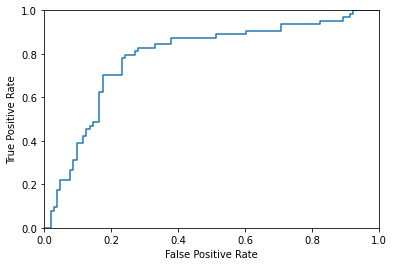

In [290]:
def plot_roc_curve(fpr,tpr): 
    plt.plot(fpr,tpr) 
    plt.axis([0,1,0,1]) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.show()

plot_roc_curve(fpr,tpr) 

In [291]:
model = Sequential()
model.add(Dense(10, activation='relu', input_shape=(T_X_train.shape[1],)))
model.add(Dense(1, activation='sigmoid'))
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

model.fit(T_X_train, T_y_train,
          batch_size=50, epochs=30,
          validation_data = (T_X_val, T_y_val))

Train on 501 samples, validate on 167 samples
Epoch 1/30
 50/501 [=>............................] - ETA: 0s - loss: 0.9245 - accuracy: 0.6600

C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


501/501 [==============================] - 0s 623us/sample - loss: 2.5337 - accuracy: 0.6188 - val_loss: 1.9095 - val_accuracy: 0.5928
Epoch 2/30
501/501 [==============================] - 0s 40us/sample - loss: 2.4042 - accuracy: 0.6148 - val_loss: 1.8248 - val_accuracy: 0.5928
Epoch 3/30
501/501 [==============================] - 0s 44us/sample - loss: 2.2951 - accuracy: 0.6148 - val_loss: 1.7185 - val_accuracy: 0.6108
Epoch 4/30
501/501 [==============================] - 0s 39us/sample - loss: 2.1679 - accuracy: 0.6168 - val_loss: 1.6173 - val_accuracy: 0.6168
Epoch 5/30
501/501 [==============================] - 0s 40us/sample - loss: 2.0397 - accuracy: 0.6208 - val_loss: 1.5196 - val_accuracy: 0.6168
Epoch 6/30
501/501 [==============================] - 0s 36us/sample - loss: 1.9147 - accuracy: 0.6267 - val_loss: 1.4252 - val_accuracy: 0.6048
Epoch 7/30
501/501 [==============================] - 0s 40us/sample - loss: 1.7926 - accuracy: 0.6208 - val_loss: 1.3410 - val_accuracy: 0.

In [292]:
from sklearn.metrics import log_loss
print('Test Log_los is ', log_loss(T_y_test, model.predict(T_X_test)))

Test Log_los is  0.7308172887935608


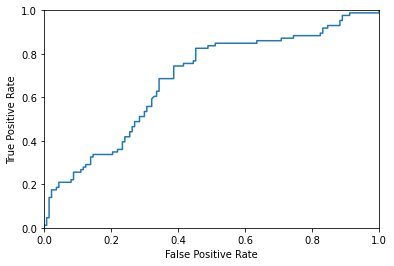

In [294]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(T_y_test ,model.predict(T_X_test))
plot_roc_curve(fpr,tpr) 

### Thyroid Disease

In [295]:
model = Sequential()
model.add(Dense(TD_y_train.shape[1], activation='softmax', input_shape=(TD_X_train.shape[1],)))
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

model.fit(TD_X_train, TD_y_train,
          batch_size=100, epochs=20,
          validation_data = (TD_X_val, TD_y_val))

Train on 2085 samples, validate on 696 samples
Epoch 1/20
 100/2085 [>.............................] - ETA: 1s - loss: 1.8990 - accuracy: 0.1500

C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


2085/2085 [==============================] - 0s 150us/sample - loss: 1.7836 - accuracy: 0.1329 - val_loss: 1.6531 - val_accuracy: 0.1609
Epoch 2/20
2085/2085 [==============================] - 0s 16us/sample - loss: 1.5329 - accuracy: 0.1914 - val_loss: 1.4139 - val_accuracy: 0.2443
Epoch 3/20
2085/2085 [==============================] - 0s 16us/sample - loss: 1.3079 - accuracy: 0.2830 - val_loss: 1.2037 - val_accuracy: 0.3534
Epoch 4/20
2085/2085 [==============================] - 0s 17us/sample - loss: 1.1128 - accuracy: 0.4158 - val_loss: 1.0238 - val_accuracy: 0.4756
Epoch 5/20
2085/2085 [==============================] - 0s 16us/sample - loss: 0.9476 - accuracy: 0.5683 - val_loss: 0.8739 - val_accuracy: 0.6293
Epoch 6/20
2085/2085 [==============================] - 0s 17us/sample - loss: 0.8116 - accuracy: 0.6882 - val_loss: 0.7514 - val_accuracy: 0.7170
Epoch 7/20
2085/2085 [==============================] - 0s 17us/sample - loss: 0.7020 - accuracy: 0.7679 - val_loss: 0.6528 - va

In [296]:
from sklearn.metrics import log_loss
print('Test Log_los is ', log_loss(TD_y_test, model.predict(TD_X_test)))

Test Log_los is  0.30546817836022516


### ROC curves for each class

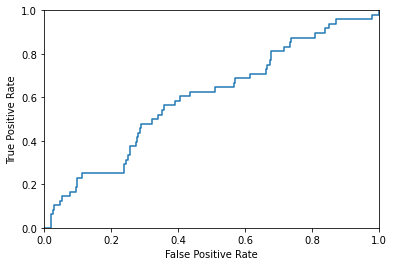

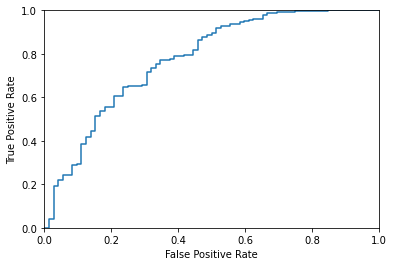

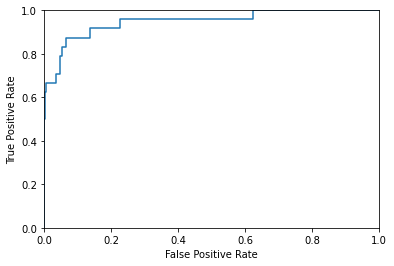

In [309]:
for i in range(3):
    fpr, tpr, thresholds = roc_curve(TD_y_test[i], model.predict(TD_X_test)[:,i])
    plot_roc_curve(fpr,tpr) 

### Boston dataset

In [248]:
from sklearn.datasets import load_boston

boston = load_boston()
boston_data = pd.DataFrame(boston.data, columns=boston.feature_names)

In [249]:
boston_target = pd.Series(boston.target)

In [250]:
cols_with_missing = [col for col in boston_data.columns
                     if boston_data[col].isnull().any()]

In [251]:
X_train, X_test, y_train, y_test = train_test_split(boston_data, boston_target, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=SEED)

In [252]:
X_train

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
297,0.14103,0.0,13.92,0.0,0.4370,5.790,58.0,6.3200,4.0,289.0,16.0,396.90,15.84
487,4.83567,0.0,18.10,0.0,0.5830,5.905,53.2,3.1523,24.0,666.0,20.2,388.22,11.45
68,0.13554,12.5,6.07,0.0,0.4090,5.594,36.8,6.4980,4.0,345.0,18.9,396.90,13.09
279,0.21038,20.0,3.33,0.0,0.4429,6.812,32.2,4.1007,5.0,216.0,14.9,396.90,4.85
294,0.08199,0.0,13.92,0.0,0.4370,6.009,42.3,5.5027,4.0,289.0,16.0,396.90,10.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.5730,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
183,0.10008,0.0,2.46,0.0,0.4880,6.563,95.6,2.8470,3.0,193.0,17.8,396.90,5.68
34,1.61282,0.0,8.14,0.0,0.5380,6.096,96.9,3.7598,4.0,307.0,21.0,248.31,20.34
216,0.04560,0.0,13.89,1.0,0.5500,5.888,56.0,3.1121,5.0,276.0,16.4,392.80,13.51


In [260]:
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='relu')
  ])

mse = tf.keras.losses.MeanSquaredError()
model.compile('adam', mse, metrics=['MSE', 'MAE'])

model.fit(X_train, y_train,
          batch_size=100, epochs=15,
          validation_data = (X_val, y_val))

Train on 284 samples, validate on 95 samples
Epoch 1/15
284/284 [==============================] - 0s 734us/sample - loss: 212.6795 - MSE: 212.6796 - MAE: 12.2239 - val_loss: 120.3602 - val_MSE: 120.3602 - val_MAE: 9.6101
Epoch 2/15
284/284 [==============================] - 0s 28us/sample - loss: 98.1367 - MSE: 98.1367 - MAE: 7.8235 - val_loss: 105.4185 - val_MSE: 105.4185 - val_MAE: 7.6889
Epoch 3/15
284/284 [==============================] - 0s 39us/sample - loss: 121.3784 - MSE: 121.3784 - MAE: 7.8824 - val_loss: 64.7804 - val_MSE: 64.7804 - val_MAE: 6.4849
Epoch 4/15
284/284 [==============================] - 0s 35us/sample - loss: 90.9554 - MSE: 90.9554 - MAE: 7.6641 - val_loss: 99.8528 - val_MSE: 99.8528 - val_MAE: 8.7081
Epoch 5/15
100/284 [=========>....................] - ETA: 0s - loss: 99.2165 - MSE: 99.2165 - MAE: 8.6132

C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


284/284 [==============================] - 0s 35us/sample - loss: 89.4778 - MSE: 89.4778 - MAE: 7.7240 - val_loss: 51.4141 - val_MSE: 51.4141 - val_MAE: 5.3982
Epoch 6/15
284/284 [==============================] - 0s 35us/sample - loss: 74.2231 - MSE: 74.2231 - MAE: 5.7167 - val_loss: 59.3019 - val_MSE: 59.3019 - val_MAE: 5.6519
Epoch 7/15
284/284 [==============================] - 0s 31us/sample - loss: 72.3112 - MSE: 72.3112 - MAE: 5.6890 - val_loss: 57.2351 - val_MSE: 57.2351 - val_MAE: 5.9551
Epoch 8/15
284/284 [==============================] - 0s 35us/sample - loss: 67.6244 - MSE: 67.6244 - MAE: 6.2934 - val_loss: 53.2475 - val_MSE: 53.2475 - val_MAE: 5.9081
Epoch 9/15
284/284 [==============================] - 0s 32us/sample - loss: 62.9674 - MSE: 62.9674 - MAE: 5.7069 - val_loss: 50.9517 - val_MSE: 50.9517 - val_MAE: 5.4028
Epoch 10/15
284/284 [==============================] - 0s 35us/sample - loss: 61.7417 - MSE: 61.7417 - MAE: 5.5257 - val_loss: 49.6995 - val_MSE: 49.6995 - 

In [261]:
from sklearn.metrics import r2_score
print('R2 score at test sample ', r2_score(y_test, model.predict(X_test)))

R2 score at test sample  0.31891632171198603


## Keras regression

In [271]:
model = keras.Sequential([
    keras.layers.Dense(1, activation='relu', input_shape=[X_train.shape[1]])
  ])

mse = tf.keras.losses.MeanSquaredError()
model.compile('adam', mse, metrics=['MSE', 'MAE'])

history = model.fit(X_train, y_train,
          batch_size=100, epochs=15,
          validation_data = (X_val, y_val))

Train on 284 samples, validate on 95 samples
Epoch 1/15
284/284 [==============================] - 0s 849us/sample - loss: 4265.2530 - MSE: 4265.2529 - MAE: 39.0029 - val_loss: 2975.0769 - val_MSE: 2975.0769 - val_MAE: 33.9645
Epoch 2/15
284/284 [==============================] - 0s 33us/sample - loss: 4145.5815 - MSE: 4145.5820 - MAE: 38.1258 - val_loss: 2886.0537 - val_MSE: 2886.0537 - val_MAE: 33.2031
Epoch 3/15
284/284 [==============================] - 0s 28us/sample - loss: 4039.9893 - MSE: 4039.9895 - MAE: 37.3663 - val_loss: 2802.6516 - val_MSE: 2802.6516 - val_MAE: 32.5308
Epoch 4/15
284/284 [==============================] - 0s 28us/sample - loss: 3942.6533 - MSE: 3942.6531 - MAE: 36.6681 - val_loss: 2725.6040 - val_MSE: 2725.6040 - val_MAE: 31.8988
Epoch 5/15
284/284 [==============================] - 0s 28us/sample - loss: 3846.6579 - MSE: 3846.6580 - MAE: 36.1684 - val_loss: 2655.5173 - val_MSE: 2655.5173 - val_MAE: 31.4259
Epoch 6/15
284/284 [=============================

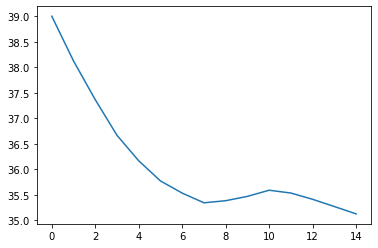

In [276]:
from matplotlib import pyplot as plt
plt.plot(history.history['MAE'])

In [259]:
from sklearn.metrics import r2_score
print('R2 score at test sample ', r2_score(y_test, model.predict(X_test)))

R2 score at test sample  -5.348119604777846


# Выводы

Многослойные нейронные сети выигрывают в точности у однослойных за счет большего количества настраиваемых параметров и "встроенного" создания доп. признаков из комбинирования старых